In [1]:
!pip install kaggle
!pip install opendatasets


import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/plhalvorsen/kvasir-v2-a-gastrointestinal-tract-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: srikrishnakireeti
Your Kaggle Key: ··········


100%|██████████| 2.32G/2.32G [01:35<00:00, 26.2MB/s]


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50V2, MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
import numpy as np
import pandas as pd
import shutil

In [11]:
rescale = preprocessing.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomContrast(factor=0.2),
    preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
    preprocessing.RandomRotation(factor=0.2),
    preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomFlip("vertical")
])

train = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=(224, 224),
    batch_size=64
).map(lambda x, y: (rescale(data_augmentation(x)), y))  # Apply rescaling and data augmentation to the images

val = image_dataset_from_directory(
    dataset_path,
    validation_split=0.4,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=(224, 224),
    batch_size=64
).map(lambda x, y: (rescale(x), y))  # Only apply rescaling to the validation images


Found 8000 files belonging to 8 classes.
Using 4800 files for training.
Found 8000 files belonging to 8 classes.
Using 3200 files for validation.


In [12]:
val_batches = tf.data.experimental.cardinality(val)
test = val.take(val_batches // 2)
val = val.skip(val_batches // 2)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.prefetch(buffer_size=AUTOTUNE)
val_ds = val.prefetch(buffer_size=AUTOTUNE)
test_ds = test.prefetch(buffer_size=AUTOTUNE)

In [8]:
base_model = MobileNetV3Large(weights='imagenet' , include_top=False, input_shape=(224, 224, 3), classifier_activation="softmax", dropout_rate=0.05)


# Add your custom head on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(8, activation='softmax')  # Assuming you have 8 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

12683000/12683000 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 7688      
                                                                 
Total params: 3004040 (11.46 MB)
Trainable params: 2979640 (11.37 MB)
Non-trainable params: 24400 (95.31 KB)
_________________________________________________________________


Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8694
Epoch 1: val_loss improved from inf to 3.02067, saving model to best_MobileNet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 150s 2s/step - loss: 0.3351 - accuracy: 0.8694 - val_loss: 3.0207 - val_accuracy: 0.1292
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.8890
Epoch 2: val_loss did not improve from 3.02067
75/75 [==============================] - 159s 2s/step - loss: 0.2804 - accuracy: 0.8890 - val_loss: 3.7904 - val_accuracy: 0.1310
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.8977
Epoch 3: val_loss did not improve from 3.02067
75/75 [==============================] - 164s 2s/step - loss: 0.2536 - accuracy: 0.8977 - val_loss: 4.5981 - val_accuracy: 0.1400
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9112
Epoch 4: val_loss did not improve from 3.02067
75/75 [==============================] - 147s 2s/step - loss: 0.2324 - accuracy: 0.9112 - val_loss: 5.1565 - val_accuracy: 0.1298
Epoch 5/50
75/75 [==============================] - ETA: 

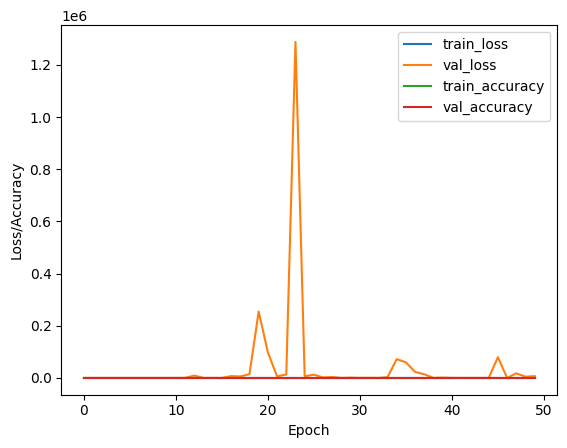

In [14]:
# %%time
# Define callbacks
checkpoint = ModelCheckpoint('best_MobileNet_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[checkpoint],
    steps_per_epoch=tf.data.experimental.cardinality(train_ds).numpy(),
    validation_steps=tf.data.experimental.cardinality(val_ds).numpy()
)

# Display training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [15]:
model.load_weights('/content/best_MobileNet_model.h5')

test_loss, test_accuracy = model.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

25/25 [==============================] - 17s 507ms/step - loss: 2.2973 - accuracy: 0.2106
Test loss: 2.29731822013855
Test accuracy: 0.21062499284744263


2/2 [==============================] - 0s 61ms/step
[[  4  87   0   0   0   0  43  72]
 [ 10 133   0   0   0   0  26  31]
 [  0   0   0   0   0   0  10 201]
 [  1  17   0   0   0   0  59 119]
 [  0   0   0   0   0   0  65 116]
 [  0   0   0   0   0   0  19 181]
 [  2  22   0   0   0   0  69 111]
 [ 10   9   0   0   0   0  45 138]]


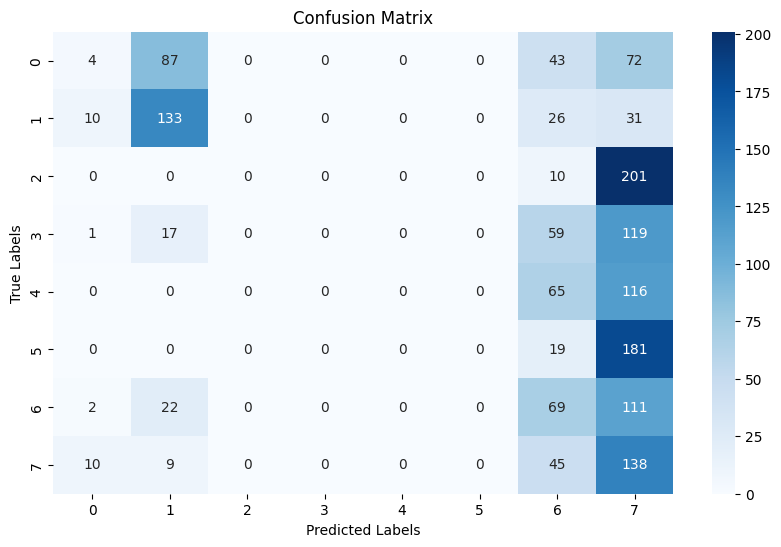

In [19]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

# Iterate over the test dataset to get true labels and predictions
for x, y in test_ds:
    y_true.extend(y.numpy().argmax(axis=1))  # Assuming y is one-hot encoded
    y_pred.extend(model.predict(x).argmax(axis=1))

cm = confusion_matrix(y_true, y_pred)

print(cm)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
